In [1]:
from fastai.text import *
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
path = Path('/content')
df = pd.read_csv(f'{path}/Game_of_Thrones_Script_Corrected.csv')

To start, let's see if we can separate out season 8 and through training on all prior seasons, identify which character is speaking which line.

In [3]:
test_df = df[df['Season'] == 'Season 8']
train_df = df[df['Season'] != 'Season 8']

In [4]:
train_df.shape

(22442, 7)

In [5]:
#Identify the top speakers in season 8
test_df['Character'].value_counts()[:30]

tyrion lannister      195
jon snow              149
daenerys targaryen    132
soldier                91
jaime lannister        87
arya stark             82
sam tarly              57
sansa stark            55
man                    48
bran stark             42
gendry baratheon       42
davos                  41
brienne                36
euron greyjoy          32
sandor clegane         32
cersei lannister       31
varys                  24
tormund                24
grey worm              22
bronn                  21
jorah mormont          18
qyburn                 18
woman                  16
lyanna                 14
beric dondarrion       13
'dolorous' edd         12
theon greyjoy          12
melisandre             11
yara greyjoy           11
nora                    8
Name: Character, dtype: int64

In [6]:
names = list(set(test_df['Character']))
# names

In [7]:
# Here we ensure that we remove any characters that don't exist in the top characters of season 8
# through checking the shape we see that we lose almost 10k rows of data
sample_train = train_df[train_df['Character'].isin(names)]
sample_train.shape

(12559, 7)

In [8]:
# to further improve our ability, we enure we're only training on characters that have at least 300 lines to evaluate
class_names = list((sample_train['Character'].loc[sample_train['Character'] != 'man'].value_counts().reset_index(name='count').query('count > 300'))['index'])
class_names

['tyrion lannister',
 'jon snow',
 'cersei lannister',
 'daenerys targaryen',
 'jaime lannister',
 'sansa stark',
 'arya stark',
 'sam tarly',
 'davos',
 'theon greyjoy',
 'bronn',
 'jorah mormont',
 'varys',
 'bran stark',
 'sandor clegane',
 'brienne']

In [9]:
new_train = train_df[train_df['Character'].isin(class_names)]
new_train.shape

(10281, 7)

In [10]:
new_train['Character'].value_counts()

tyrion lannister      1565
jon snow               984
cersei lannister       974
daenerys targaryen     917
jaime lannister        858
sansa stark            729
arya stark             701
sam tarly              499
davos                  487
theon greyjoy          443
bronn                  372
jorah mormont          363
varys                  362
bran stark             357
sandor clegane         336
brienne                334
Name: Character, dtype: int64

In [11]:
new_test = test_df[test_df['Character'].isin(class_names)]
new_test.shape

(1014, 7)

In [12]:
new_test['Character'].value_counts()

tyrion lannister      195
jon snow              149
daenerys targaryen    132
jaime lannister        87
arya stark             82
sam tarly              57
sansa stark            55
bran stark             42
davos                  41
brienne                36
sandor clegane         32
cersei lannister       31
varys                  24
bronn                  21
jorah mormont          18
theon greyjoy          12
Name: Character, dtype: int64

# Building a Generic Game of Thrones Language Model

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
lm_train_df, lm_valid_df = train_test_split(df, test_size=.1)

In [15]:
data_lm = TextLMDataBunch.from_df(path='/content',train_df=lm_train_df,valid_df=lm_valid_df,text_cols='Sentence', bs=64, max_vocab=100000, min_freq=1)

In [16]:
data_lm.show_batch()

idx,text
0,xxmaj winter is coming for him . xxbos xxmaj he seems pleased . xxbos xxmaj you should xxbos xxmaj those are words . xxbos xxmaj everything they say is true . xxmaj about xxmaj jaime and me . xxbos xxmaj gambler at heart . xxmaj would n't have guessed . xxbos xxmaj which xxmaj lord xxmaj tyrion will say was stolen from him . xxmaj the only man who could
1,"xxmaj every time the xxmaj qartheen shut their gates on a traveler , the garden grows . xxbos 15 ? xxbos xxmaj what did your mother call you ? xxbos xxmaj girls will think of us with their lovers inside them . xxbos xxmaj we need every man we can get . xxbos i think they might . xxmaj they 're weak . xxmaj they put too much value on"
2,"very involved affair . xxmaj the word extravagant has been used . xxbos xxmaj how much ? xxbos xxmaj hodor . xxmaj hodor , get his knife . xxmaj cut me loose . xxbos xxmaj your name is xxmaj theon xxmaj greyjoy . xxmaj last surviving son of xxmaj balon xxmaj greyjoy , xxmaj lord of the xxmaj iron xxmaj islands , do you hear me ? xxmaj theon ."
3,"xxmaj so you want to advise me . xxmaj very well . xxmaj what would you have me do with him ? i swore i would kill him if he ever returned . xxbos xxmaj wun xxmaj wun , to the sea . xxbos xxmaj you 'll want to take your vow before a heart tree as your xxmaj uncle did . xxbos xxmaj clegane , we 're here for"
4,"get on with it ! xxmaj but do n't call me murderer and pretend that you 're not . xxbos xxmaj he was a fine man , your father . xxmaj what the xxmaj mad xxmaj king did to him was a terrible crime . xxbos xxmaj he was my husband . xxmaj my king . xxbos xxmaj who sent us ? xxbos xxmaj how many xxmaj dornishmen does it"


In [17]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.7)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


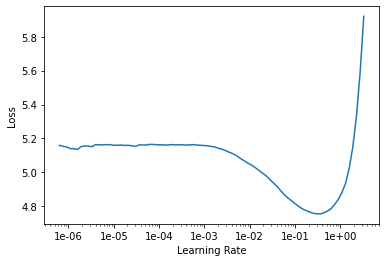

In [18]:
learn.lr_find()
learn.recorder.plot()

In [19]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.850009,3.398875,0.330112,00:09


In [20]:
learn.unfreeze()
learn.fit_one_cycle(4, 1e-3,moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.377513,3.285477,0.342232,00:12
1,3.252940,3.228561,0.351964,00:12
2,3.104008,3.201200,0.357812,00:12
3,2.982763,3.204411,0.358996,00:12


In [21]:
text = 'The King'
n_words = 40
n_sentences=5

print('\n'.join(learn.predict(text, n_words) for _ in range(n_sentences)))

The King in the North ! The Knight in the North ! Lies in . The Ser ! The King in the North ! The King in the North
The King 's Landing is in a deserted city . i have no doubt you might be spirit welcome here . xxbos Understanding it ? xxbos Here that are you and Jory , is your little brother
The King is obeyed . xxbos i know billy 's height – xxbos If my boy wo not touch us , you 're too away from me . So and Aunt Lysa . We 'll drag the
The King is dead . Himself king owned by the gods was destroyed by marriage . a fire is burning in the problem ! This is the last thing there is . The wolf has been gone for a
The King in the North ! xxbos How did you find a bit of a bastard in his purse before leave ? xxbos No . That 's what you mean , Bert . xxbos Podrick .


In [22]:
learn.save('fine_tuned')
learn.save_encoder('fine_tuned_enc')

# Character Classification

In [23]:
clas_train_df, clas_valid_df = train_test_split(new_train, test_size=0.2)
clas_train_df.shape, clas_valid_df.shape

((8224, 7), (2057, 7))

In [24]:
data_clf = TextClasDataBunch.from_df(path = '/content', train_df = clas_train_df, valid_df = clas_valid_df, test_df=new_test, vocab=data_lm.vocab, text_cols='Sentence', label_cols= 'Character', bs=64)

In [36]:
learn = text_classifier_learner(data_clf, arch = AWD_LSTM, drop_mult=0.6)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


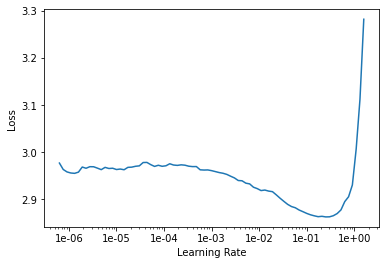

In [37]:
learn.load_encoder('fine_tuned_enc')

# Find best learning rate for our classifier
learn.lr_find()
learn.recorder.plot()

In [38]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.633522,2.541672,0.167234,00:03


In [39]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-3/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.551109,2.508523,0.190083,00:03


In [40]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(1e-3/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.522212,2.474703,0.203695,00:05


In [41]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-3/(2.6**4),1e-1), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.459982,2.567052,0.189597,00:07
1,2.540095,2.572853,0.176471,00:07
2,2.584222,2.669621,0.175498,00:07
3,2.501565,2.547753,0.203695,00:06
4,2.397386,2.463082,0.215362,00:07
5,2.229835,2.434822,0.227516,00:08
6,1.971711,2.495650,0.239669,00:07
7,1.667412,3.442835,0.249392,00:07
8,1.517235,2.740769,0.249392,00:07
9,1.334498,2.772774,0.249878,00:07


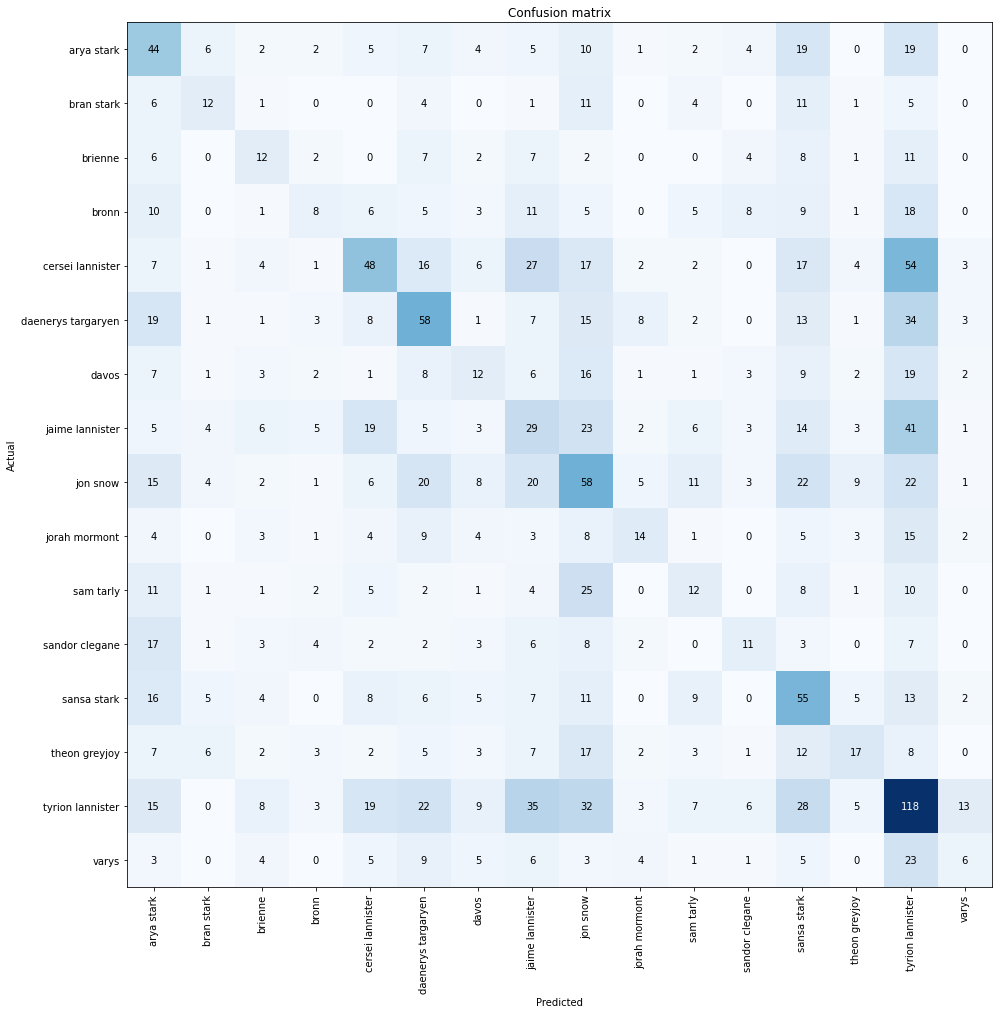

In [42]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(14,14))

Interesting. It seems Tyrion is really the only one with decent odds of correct classification. This is most likely due to the overwhelming amount of dialog he has compared to the other characters. Lannisters and Starks do seem to have slightly better odds of proper classification, so lets see how attempting to classifying family works.

# Last Name Classifier

In [43]:
df.loc[df['Character'].str.split().str.len() == 2, 'last name'] = df['Character'].str.split().str[-1]
df['last name'].value_counts()[:10]

lannister    4581
stark        2939
snow         1133
targaryen    1101
baratheon     718
greyjoy       689
tarly         556
baelish       483
tyrell        465
mormont       462
Name: last name, dtype: int64

In [46]:
last_names = list((df['last name'].value_counts().reset_index(name='count').query('count > 500'))['index'])
last_names

['lannister', 'stark', 'snow', 'targaryen', 'baratheon', 'greyjoy', 'tarly']

We'll first attempt as is, but we'll create an additional version of this data to test for comparison on how we classify Jon Snow. In the additional version, we'll see how changing him to a Stark affects our outcome.

In [70]:
df_snow = df
df_snow['last name'].replace('snow', 'stark', inplace = True)

In [51]:
first_class = df[df['last name'].isin(last_names)]
first_class = first_class[['Sentence', 'last name']]
first_class.head()

,Sentence,last name
15,Go on. Father's watching.,snow
16,And your mother.,snow
18,Thank you.,stark
20,And which one of you was a marksman at ten? Ke...,stark
21,"Don't think too much, Bran.",snow


In [50]:
clas_train_df, clas_valid_df = train_test_split(first_class, test_size=0.2)
clas_train_df.shape, clas_valid_df.shape

((9373, 2), (2344, 2))

In [60]:
data_clf = TextClasDataBunch.from_df(path = '/content', train_df = clas_train_df, valid_df = clas_valid_df, vocab=data_lm.vocab, text_cols='Sentence', label_cols= 'last name', bs=64)

In [61]:
learn = text_classifier_learner(data_clf, arch = AWD_LSTM, drop_mult=0.6)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


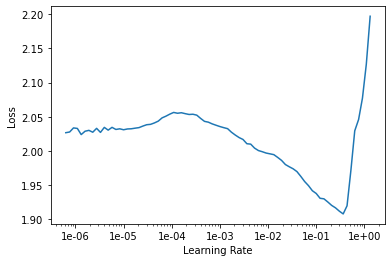

In [62]:
learn.load_encoder('fine_tuned_enc')

# Find best learning rate for our classifier
learn.lr_find()
learn.recorder.plot()

In [63]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.644461,1.581070,0.411263,00:04


In [64]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-3/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.600922,1.566428,0.424915,00:04


In [65]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(1e-3/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.560640,1.540109,0.438140,00:07


In [66]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-3/(2.6**4),1e-1), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.563475,1.575462,0.408703,00:08
1,1.569114,1.591415,0.394198,00:08
2,1.603897,1.583125,0.412969,00:08
3,1.559425,1.672710,0.428328,00:07
4,1.426203,1.681410,0.426621,00:09
5,1.349601,1.555029,0.446672,00:09
6,1.188766,1.787592,0.460751,00:09
7,1.017398,1.638615,0.458191,00:08
8,0.879926,1.682788,0.460324,00:07
9,0.828280,1.811274,0.462457,00:08


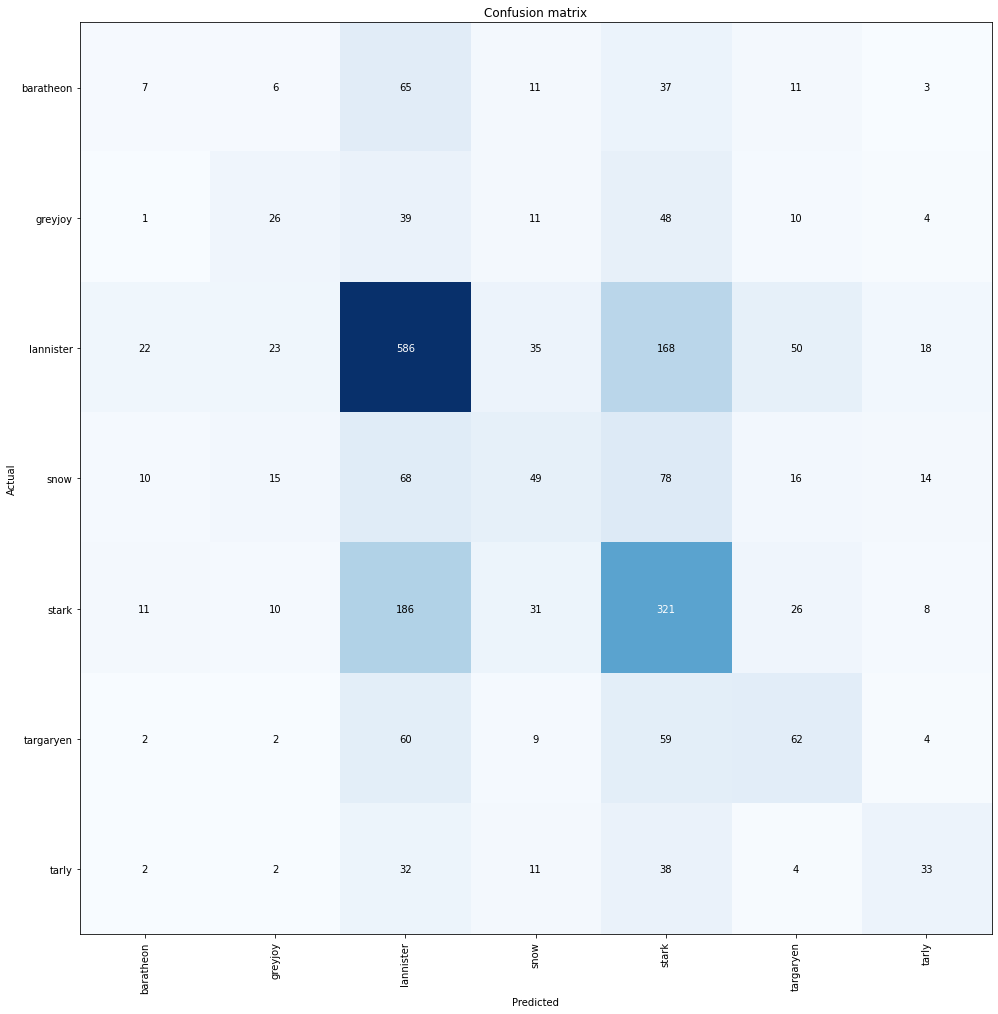

In [67]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(14,14))

We see a siginificant improvement over individual character classification here. We also see a heavy focus on Lannister and Stark classification, again, most likely due to the number of observations of these two families. What's especially interesting here is the classification of Jon Snow. It seems he's only slightly more likely to be classified as a Stark than he is a Lannister and ironically not very likely to be classified as a Targaryen. Due to his being raised by Starks, we'll next see how changing his classification effects our results.

# Snow to Stark Classification

In [71]:
second_class = df_snow[df_snow['last name'].isin(last_names)]
second_class = second_class[['Sentence', 'last name']]
second_class.head()

,Sentence,last name
15,Go on. Father's watching.,stark
16,And your mother.,stark
18,Thank you.,stark
20,And which one of you was a marksman at ten? Ke...,stark
21,"Don't think too much, Bran.",stark


In [73]:
clas_train_df, clas_valid_df = train_test_split(second_class, test_size=0.2)
clas_train_df.shape, clas_valid_df.shape

((9373, 2), (2344, 2))

In [74]:
data_clf = TextClasDataBunch.from_df(path = '/content', train_df = clas_train_df, valid_df = clas_valid_df, vocab=data_lm.vocab, text_cols='Sentence', label_cols= 'last name', bs=64)

In [75]:
learn = text_classifier_learner(data_clf, arch = AWD_LSTM, drop_mult=0.6)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


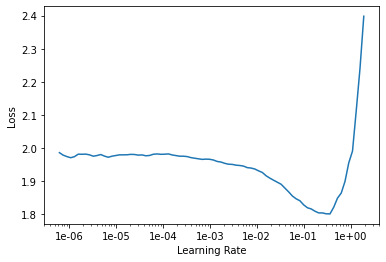

In [76]:
learn.load_encoder('fine_tuned_enc')

# Find best learning rate for our classifier
learn.lr_find()
learn.recorder.plot()

In [77]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.441657,1.370634,0.473976,00:03


In [78]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-3/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.387708,1.345036,0.483788,00:04


In [79]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(1e-3/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.356435,1.339127,0.489761,00:06


In [80]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-3/(2.6**4),1e-1), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.336362,1.343607,0.483788,00:09
1,1.371542,1.510017,0.395478,00:07
2,1.398872,1.387593,0.448805,00:08
3,1.337795,1.375998,0.476536,00:09
4,1.277988,3.734442,0.493601,00:08
5,1.200715,2.129169,0.501706,00:08
6,1.063410,1.728497,0.502986,00:08
7,0.925475,1.439467,0.503413,00:08
8,0.811171,1.502993,0.511092,00:08
9,0.746553,1.634245,0.500853,00:08


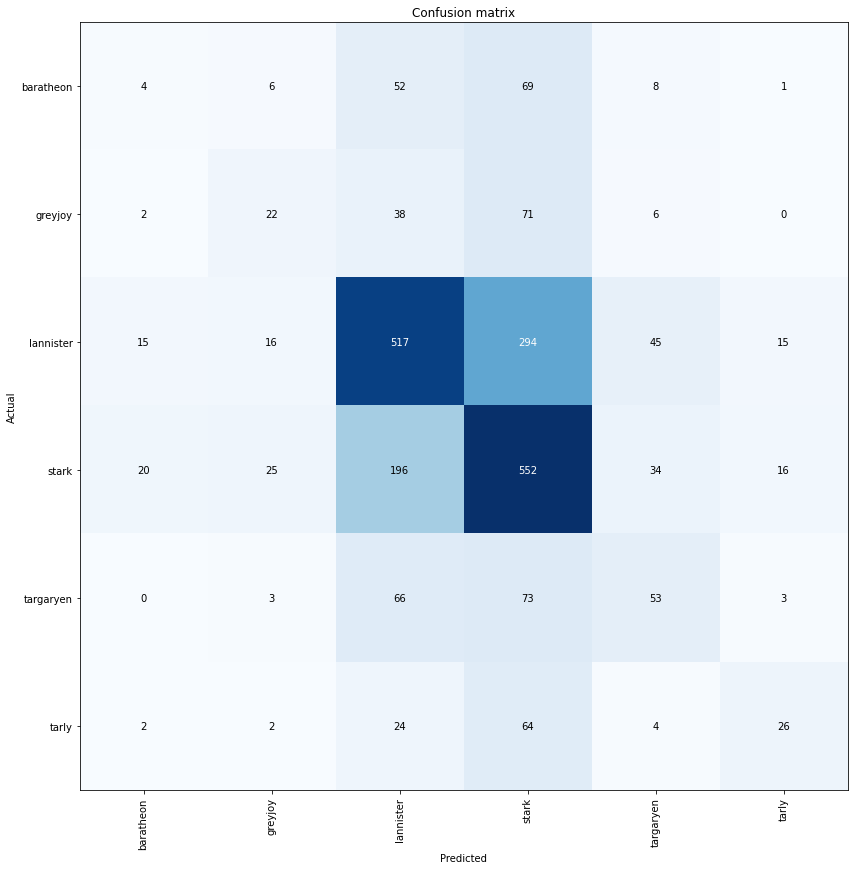

In [81]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12))

Again we see an improvement in performance! Starks and Lannisters definitely seem to be the prominent families here. Another interesting takeaway from this plot is the likelihood of classification for both Greyjoys and Tarlys. Both of these key characters spent close aproximation with the Starks and both have significantly higher probabilites of being misclassified as a Stark as opposed to any other family

# Stark v Lannister

In [85]:
binary = second_class[second_class['last name'].isin(['stark', 'lannister'])]
binary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8653 entries, 15 to 23905
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   8653 non-null   object
 1   last name  8653 non-null   object
dtypes: object(2)
memory usage: 202.8+ KB


In [86]:
clas_train_df, clas_valid_df = train_test_split(binary, test_size=0.2)
clas_train_df.shape, clas_valid_df.shape

((6922, 2), (1731, 2))

In [87]:
data_clf = TextClasDataBunch.from_df(path = '/content', train_df = clas_train_df, valid_df = clas_valid_df, vocab=data_lm.vocab, text_cols='Sentence', label_cols= 'last name', bs=64)

In [88]:
learn = text_classifier_learner(data_clf, arch = AWD_LSTM, drop_mult=0.6)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


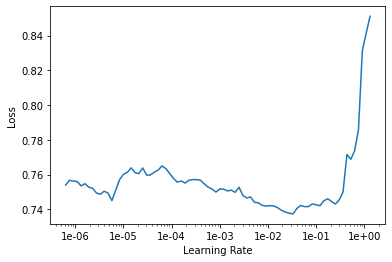

In [89]:
learn.load_encoder('fine_tuned_enc')

# Find best learning rate for our classifier
learn.lr_find()
learn.recorder.plot()

In [90]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.679447,0.641082,0.626228,00:03


In [91]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-3/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.663895,0.639020,0.627961,00:03


In [92]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(1e-3/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.649030,0.622624,0.648758,00:04


In [93]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-3/(2.6**4),1e-1), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.640222,0.638727,0.629116,00:06
1,0.646867,0.651723,0.617562,00:06
2,0.668263,1.053800,0.495090,00:06
3,0.615702,0.618921,0.664934,00:06
4,0.552827,0.597067,0.670711,00:06
5,0.494854,0.651626,0.630849,00:06
6,0.395865,0.866483,0.659734,00:06
7,0.311199,0.825494,0.678221,00:06
8,0.249816,0.927684,0.683420,00:06
9,0.231943,0.955279,0.679954,00:06


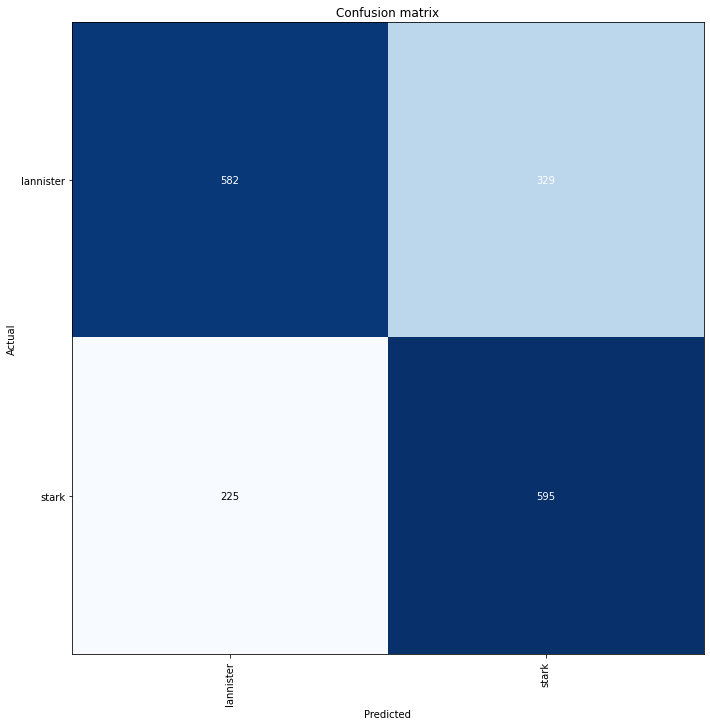

In [94]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10,10))

Dwindling things down to just the two main families provides our best performance improvement yet. It also would appear that we're actually better at classifying Starks just a little bit more than we are at Lannisters. Could this be due to the Starks having characters that are typically more negative in sentiment and the Lannisters having a wider range of character sentiments?